**Exercise 2.5 from Sutton, Richard S. ; Barto, Andrew G.: *Reinforcement Learning: An Introduction (pg52)***

*Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q(a) start out equal and then take independent random walks. Prepare plots like Figure 2.1 for an action-value method using sample averages, incrementally computed by α = 1/k, and another action-value method using a constant step-size parameter, α = 0.1. Use ε = 0.1 and, if necessary, runs longer than 1000 plays.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
STEPS = 2000 # arbitrary > 1000
ALPHA = 0.1 # step size parameter, can be constant or variable.
EPSILON = 0.1
N_BANDITS = 500 # arbitrary, but this represents the non-stationary problem where the bandit changes over time, so we should have multiple bandits
ARMS = 10 # 10-armed testbed

In [3]:
def random_walk(vec):
    """
    Args:
        vec: vector where each element will take a random walk
    """
    new_vec = []
    walk_set = [-1, 1, 0]
    for i, el in enumerate(vec):
        new_vec.append(el + np.random.choice(walk_set))
    return new_vec

In [4]:
def epsilon_greedy(vec, epsilon, arms):
    """
    Args:
        vec: vector holding value estimates for each action a at each timestep t
        epsilon: the probability with which the agent doesn't select the greedy action
        arms: the number of actions the bandit could select
    Returns: 
        i: the column index of the action to select
    """
    r = random.uniform(0, 1) # Choose random value to simulate whether the agent chooses greedy or non greedy, according to epsilon
    i = np.argmax(vec) # Find index of highest value action
    column_indexes = list(range(0,arms))
    
    # Choose a random action (not the max) if we fall into epsilon
    if r <= epsilon:
        column_indexes.remove(i)
        i = random.choice(column_indexes) # Choose a random action index that is not the greedy choice
        return i
    
    # Choose greedily if we don't fall into epsilon
    else:
        return i  

In [5]:
def multi_task(epsilon=EPSILON, max_iter=STEPS, tasks=N_BANDITS, arms=ARMS, alpha=ALPHA):
    """
    Args:
        vec: vector holding value estimates for each action a at each timestep t
        max_iter = the number of steps taken by the value function in the random walk
        tasks = the number of random bandits we will average across
        arms: the number of actions the bandit could select
        alpha = the constant stepsize parameter used to calcuate new reward estimates
    Returns: 
        constR: reward estimated via constant stepsizes at each timestep t
        variabR: reward estimated via variable stepsizes at each timestep t
    """

    # We want matrices for all possible combinations of bandits and actions performed by each one
    rows, cols = tasks, arms
    
    # Create true value of arms with random walk
    # Q is the weighted average of the past rewards
    q = np.array( [([0]*arms) for i in range(rows)] ) 
    constQ = np.array( [([0]*cols) for i in range(rows)] )
    variabQ = np.array( [([0]*cols) for i in range(rows)] )
    # N is the 
    constN = np.array( [([0]*cols) for i in range(rows)] )
    variabN = np.array( [([0]*cols) for i in range(rows)] )
    # R is the rewards obtained at each step
    constR = np.zeros(max_iter)
    variabR = np.zeros(max_iter)
    
    # Iteration loop (within each iteration we have a random number of bandits (tasks) that we will average over)
    for i in range(max_iter):
        
        # Task loop (the random bandits we cycle through per each iteration)
        for j in range(tasks):
            # random walk of each arm
            task_q = q[j, :]
            task_q = random_walk(task_q)
            q[j,:] = task_q
        
            # CONSTANT STEPSIZE
            
            # get one random arm from set of tasks
            task_constQ = constQ[j,:]
            task_constN = constN[j,:]
            
            # find the arm to pick
            action_index_c = epsilon_greedy(task_constQ, epsilon, arms)
            
            # get reward
            reward_const = q[j,action_index_c]
            
            # add reward to total rewards for this iteration (to be averaged later)
            constR[i] = constR[i] + reward_const
            
            # update estimated value of arm based on observation
            task_constQ[action_index_c] = task_constQ[action_index_c] + alpha*(reward_const-task_constQ[action_index_c])
            constQ[j,:] = task_constQ

            # update number of times arm has been selected
            task_constN[action_index_c] = task_constN[action_index_c] + 1
            constN[j:] = task_constN
            
            # VARYING STEPSIZE
            
            # get one arm from set of tasks
            task_variabQ = variabQ[j,:]
            task_variabN = variabN[j,:]
            
            # find arm to pick
            action_index_v = epsilon_greedy(task_variabQ, epsilon, arms)
            
            # get reward from true values of arms
            reward_variab = q[j,action_index_v]
            
            # add reward to total rewards for this iteration
            variabR[i] = variabR[i] + reward_variab
            
            # update number of times arm has been selected
            task_variabN[action_index_v] = task_variabN[action_index_v] + 1
            variabN[j,:] = task_variabN
            
            # set stepsize to 1 for first iteration
            if i == 0:
                beta = 1
            else:
                beta = (1/task_variabN[action_index_v])
            
            # update estimated value of action based on observation 
            task_variabQ[action_index_v] = task_variabQ[action_index_v] +\
                                           beta*(reward_variab-task_variabQ[action_index_v])
            variabQ[j,:] = task_variabQ
        
        # get average reward across all bandits for each iteration
        constR[i] = constR[i] / tasks
        variabR [i] = variabR[i] / tasks
        
    return constR, variabR

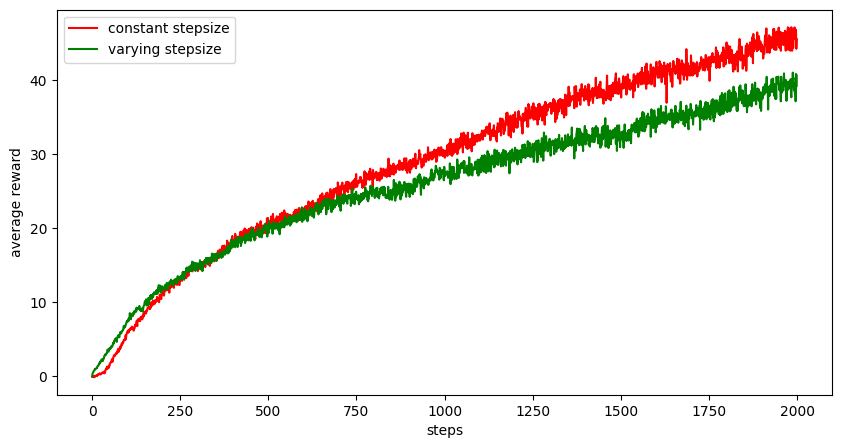

In [7]:
# calculate and plot
R_c_step, R_v_step = multi_task()

fig = plt.figure(figsize=(10,5))
fig.add_subplot(111)
plt.xlabel('steps')
plt.ylabel('average reward')
plt.plot(R_c_step, 'r', label='constant stepsize')
plt.plot(R_v_step, 'g', label='varying stepsize')
plt.legend(loc='upper left')
plt.savefig('ex2_3.png', dpi=300)
plt.show()

After 2000 steps of the value function, each following a random walk to simulate a non-stationary problem, the algorithm with constant step sizes performed better than the algorithm with varying step sizes. The constant step size updating formula is the following:

$Q_{k+1} = Q_k + \alpha[R_k - Q_k]$

This means that recent updated to our estimate of an arm's values are weighted more heavily than those in the past (weighted average), ideal for a problem with non-stationary values. In contrast, the varying step size weights all reward equally, which is worse at solving this problem.

The variable step size ($\alpha=1/k$, which reduces over time) can be very useful in stationary problems such as the tic-tac-toe since exploration reduces in time, as it is more likely the agent already knows optimal actions. We fix the step size to a constant because, this way, more recent values weight more than older ones.